In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# ! git clone https://github.com/mlfoundations/wise-ft.git

In [75]:
import sys
sys.path.append('wise-ft')

In [76]:
from src.models.modeling import ImageEncoder, ClassificationHead, ImageClassifier
from src.models.finetune import finetune
from src.models.eval import evaluate

from clip import clip

import torch
import numpy as np
import argparse
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

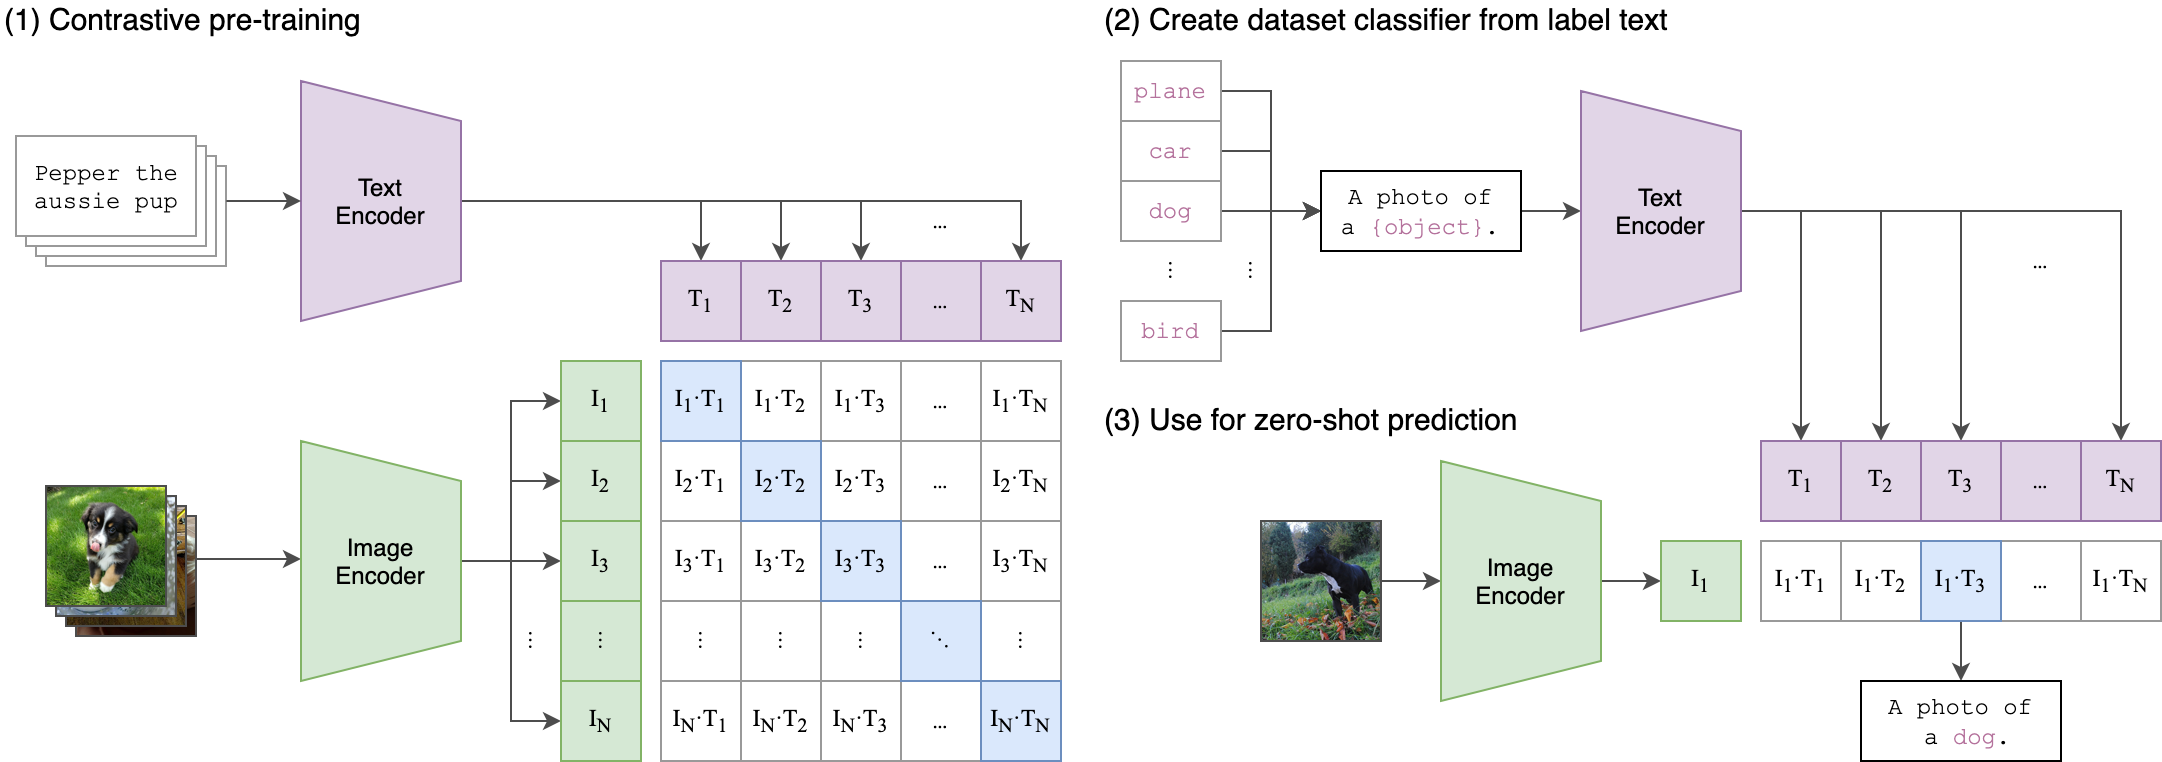

In [ ]:
class ImageClassifier(torch.nn.Module):
    def __init__(self, image_encoder, classification_head, process_images=True):
        super().__init__()
        self.image_encoder = image_encoder
        self.classification_head = classification_head
        self.process_images = process_images
        if self.image_encoder is not None:
            self.train_preprocess = self.image_encoder.train_preprocess
            self.val_preprocess = self.image_encoder.val_preprocess

    def forward(self, inputs):
        if self.process_images:
            inputs = self.image_encoder(inputs)
        outputs = self.classification_head(inputs)
        return outputs

    def save(self, filename):
        print(f'Saving image classifier to {filename}')
        utils.torch_save(self, filename)

    @classmethod
    def load(cls, filename):
        print(f'Loading image classifier from {filename}')
        return utils.torch_load(filename)

In [56]:
from src.models.probing import finetune_probing, evaluate_probing

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
args = argparse.Namespace(
    device=device, train_dataset='ImageNet', data_location='datasets', batch_size=128, ls=0, warmup_length=1, epochs=1, lr=3e-5, wd=0.1,
    task='rotations', num_iters=-1, load='models/pretrained_random_head.pt', results_db='logs/results', freeze_encoder=True, save='models',
    eval_datasets=['ImageNet']
)

In [59]:
finetune_probing(args)

Loading image classifier from models/pretrained_random_head.pt
Fine-tuning a linear classifier
Using devices [0]
Getting features from cache/ImageNet/train


  0%|          | 0/10010 [00:00<?, ?it/s]

Train Epoch: 0 [0% 0/10010]	Loss: 1.387451	Data (t) 0.000	Batch (t) 0.002
Train Epoch: 0 [10% 1000/10010]	Loss: 1.375031	Data (t) 0.000	Batch (t) 0.001
Train Epoch: 0 [20% 2000/10010]	Loss: 1.370735	Data (t) 0.000	Batch (t) 0.001
Train Epoch: 0 [30% 3000/10010]	Loss: 1.361343	Data (t) 0.000	Batch (t) 0.002
Train Epoch: 0 [40% 4000/10010]	Loss: 1.348991	Data (t) 0.000	Batch (t) 0.001
Train Epoch: 0 [50% 5000/10010]	Loss: 1.351212	Data (t) 0.000	Batch (t) 0.001
Train Epoch: 0 [60% 6000/10010]	Loss: 1.356339	Data (t) 0.000	Batch (t) 0.001
Train Epoch: 0 [70% 7000/10010]	Loss: 1.345909	Data (t) 0.000	Batch (t) 0.001
Train Epoch: 0 [80% 8000/10010]	Loss: 1.343170	Data (t) 0.000	Batch (t) 0.002
Train Epoch: 0 [90% 9000/10010]	Loss: 1.348923	Data (t) 0.000	Batch (t) 0.001
Train Epoch: 0 [100% 10000/10010]	Loss: 1.338341	Data (t) 0.000	Batch (t) 0.002
Saving model to models/rotations_checkpoint_1.pt
Saving image classifier to models/rotations_checkpoint_1.pt
Evaluating on ImageNet
Getting feat

  0%|          | 0/391 [00:00<?, ?it/s]

ImageNet Top-1 accuracy: 0.4725
Results saved to results.


'models/rotations_checkpoint_1.pt'

In [60]:
image_classifier = ImageClassifier.load('models/rotations_checkpoint_1.pt')

Loading image classifier from models/rotations_checkpoint_1.pt


In [61]:
metrics = evaluate_probing(image_classifier, args)

Evaluating on ImageNet
Getting features from cache/ImageNet/val


  0%|          | 0/391 [00:00<?, ?it/s]

ImageNet Top-1 accuracy: 0.4725
Results saved to results.


## Zero-shot модель

In [ ]:
clip_model, train_preprocess, test_preprocess = clip.load('ViT-B/16')

In [21]:
from src.datasets import ImageNet
dataset = ImageNet(train_preprocess, location='datasets', batch_size=64, num_workers=4)

In [28]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in dataset.classnames]).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)

text_features /= text_features.norm(dim=-1, keepdim=True)

In [36]:
args = argparse.Namespace(device=device, model='ViT-B/16', cache_dir='cache')

image_encoder = ImageEncoder(args)

classification_head = ClassificationHead(
    normalize=True,
    weights=text_features.to(torch.float32)
)

zeroshot_model = ImageClassifier(image_encoder, classification_head)

torch.save(zeroshot_model, 'models/zeroshot.pt')

In [45]:
# ID

args = argparse.Namespace(
    device='cuda', eval_datasets=['ImageNet'],
    data_location='datasets', batch_size=128, results_db='logs/zeroshot.txt', freeze_encoder=False
)

evaluate(zeroshot_model, args)

Evaluating on ImageNet


  0%|          | 0/391 [00:00<?, ?it/s]

ImageNet Top-1 accuracy: 0.6660
Results saved to zeroshot.json.


{'device': 'cuda',
 'eval_datasets': ['ImageNet'],
 'data_location': 'datasets',
 'batch_size': 128,
 'results_db': 'zeroshot.json',
 'freeze_encoder': False,
 'ImageNet:top1': 0.66596}

## Out Of Distribution

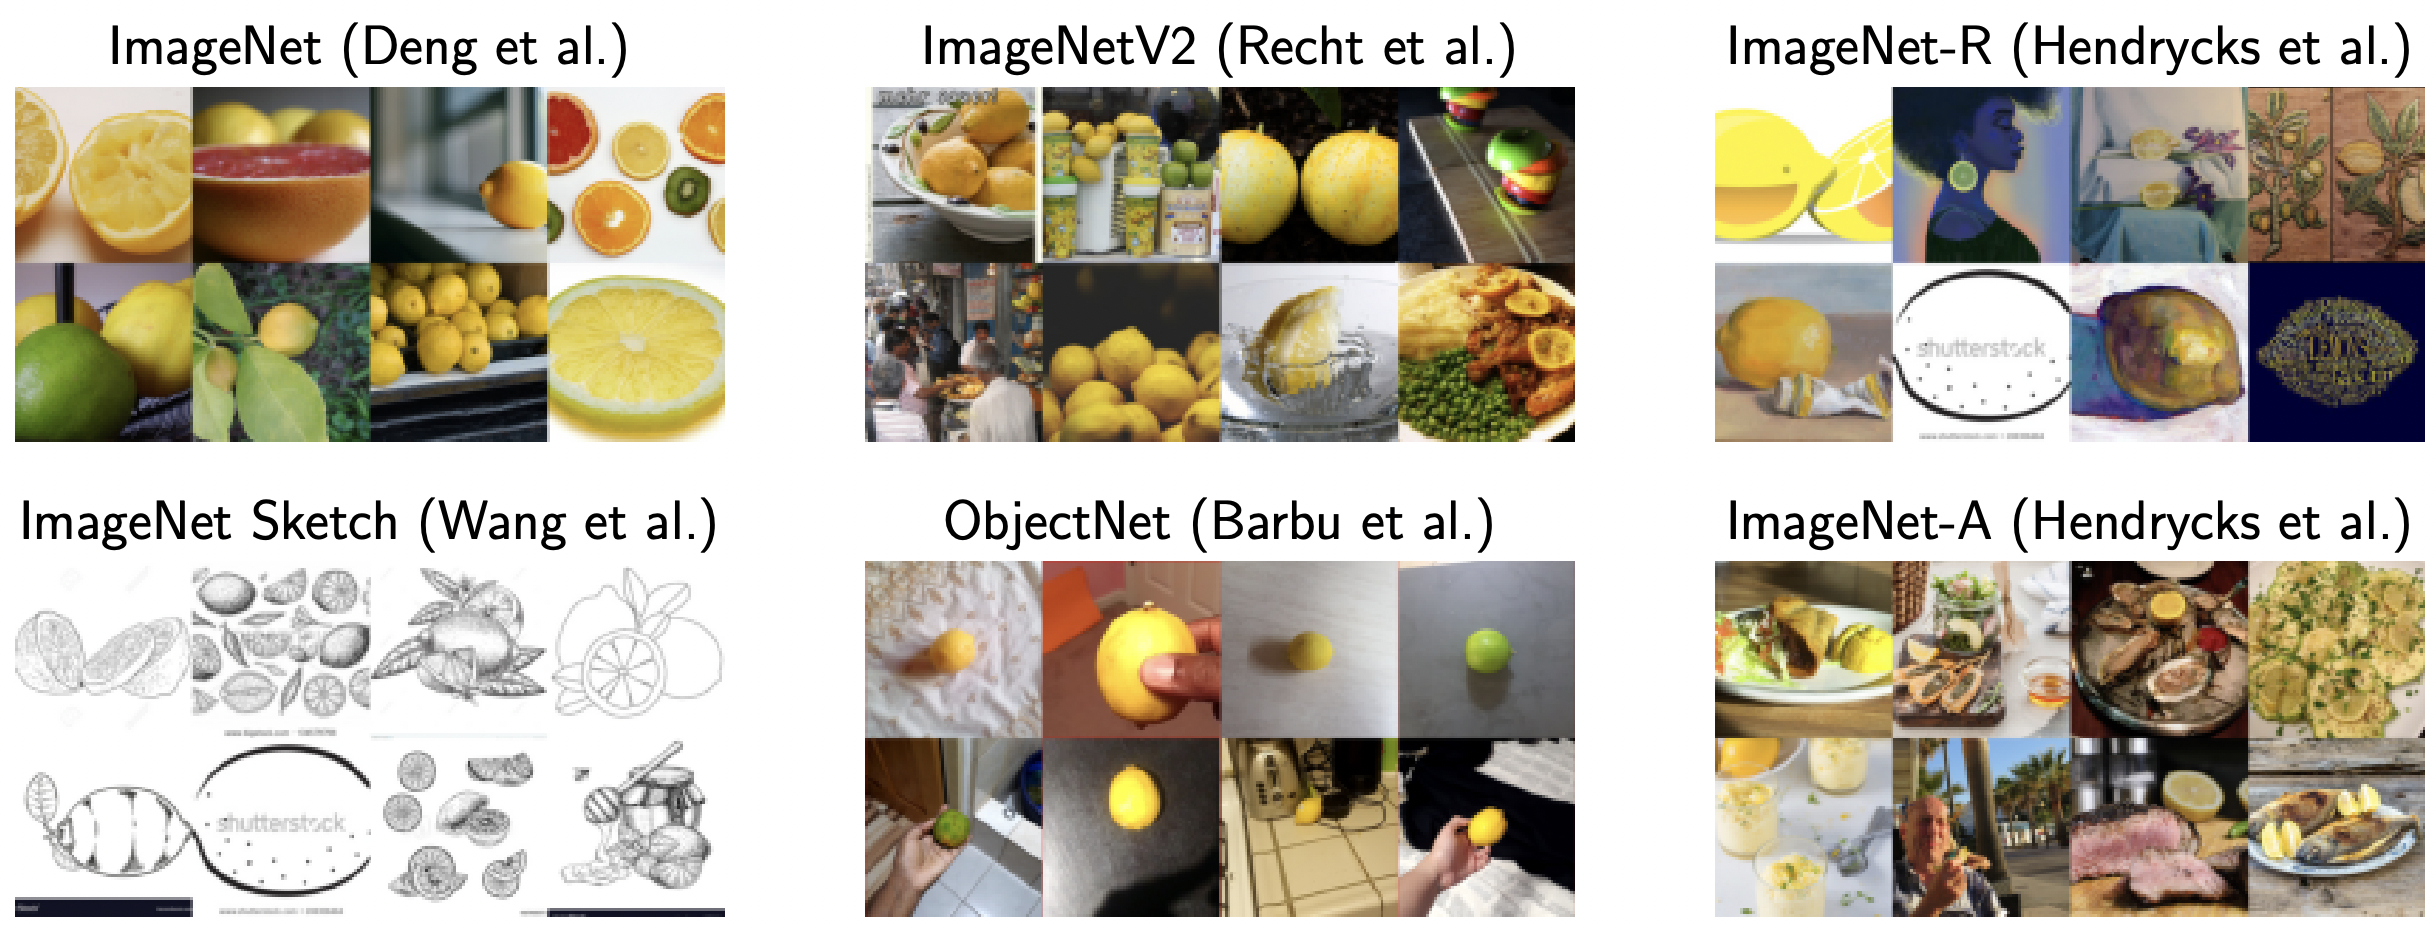

In [47]:
args = argparse.Namespace(
    device='cuda', eval_datasets=['ImageNetVidRobust', 'ImageNetSketch', 'ImageNetA', 'ImageNetR'],
    data_location='datasets', batch_size=128, results_db='zeroshot.txt', freeze_encoder=False
)

In [49]:
from src.models.eval import evaluate

metrics = evaluate(zeroshot_model, args)

Evaluating on ImageNetVidRobust


  0%|          | 0/174 [00:00<?, ?it/s]

ImageNetVidRobust Top-1 accuracy: 0.8570
ImageNetVidRobust pm0: 0.8828
Evaluating on ImageNetSketch


  0%|          | 0/398 [00:00<?, ?it/s]

ImageNetSketch Top-1 accuracy: 0.4595
Evaluating on ImageNetA


  0%|          | 0/59 [00:00<?, ?it/s]

ImageNetA Top-1 accuracy: 0.4789
Evaluating on ImageNetR


  0%|          | 0/235 [00:00<?, ?it/s]

ImageNetR Top-1 accuracy: 0.7380
Results saved to zeroshot.txt.


In [52]:
top1_accuracy = np.mean([metrics[key] for key in metrics.keys() if 'top1' in key])
top1_accuracy

0.6333528485011539

## LP-FT

### Linear Probe

In [53]:
args = argparse.Namespace(
    device=device, train_dataset='ImageNet', data_location='datasets', batch_size=128, ls=0, warmup_length=1, epochs=10, lr=3e-5, wd=0.1,
    load='models/pretrained_random_head.pt', results_db='results', freeze_encoder=True, save='models/linear_probe/'
)

finetune(args)

In [6]:
lp_model = ImageClassifier.load('models/linear_probe/checkpoint_10.pt')

Loading image classifier from models/linear_probe/checkpoint_10.pt


In [8]:
# ID

args = argparse.Namespace(
    device='cuda', eval_datasets=['ImageNet'],
    data_location='datasets', batch_size=128, results_db='logs/lp.txt', freeze_encoder=False
)

evaluate(lp_model, args)

Evaluating on ImageNet


/home/amshabalin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/391 [00:00<?, ?it/s]

ImageNet Top-1 accuracy: 0.6475
Results saved to logs/lp.txt.


{'device': 'cuda',
 'eval_datasets': ['ImageNet'],
 'data_location': 'datasets',
 'batch_size': 128,
 'results_db': 'logs/lp.txt',
 'freeze_encoder': False,
 'ImageNet:top1': 0.64746}

In [9]:
# OOD

args = argparse.Namespace(
    device='cuda', eval_datasets=['ImageNetVidRobust', 'ImageNetSketch', 'ImageNetA', 'ImageNetR'],
    data_location='datasets', batch_size=128, results_db='logs/lp.txt', freeze_encoder=False
)

metrics = evaluate(lp_model, args)

top1_accuracy = np.mean([metrics[key] for key in metrics.keys() if 'top1' in key])
top1_accuracy

Evaluating on ImageNetVidRobust


  0%|          | 0/174 [00:00<?, ?it/s]

ImageNetVidRobust Top-1 accuracy: 0.8277
ImageNetVidRobust pm0: 0.8503
Evaluating on ImageNetSketch


  0%|          | 0/398 [00:00<?, ?it/s]

ImageNetSketch Top-1 accuracy: 0.4069
Evaluating on ImageNetA


  0%|          | 0/59 [00:00<?, ?it/s]

ImageNetA Top-1 accuracy: 0.4385
Evaluating on ImageNetR


  0%|          | 0/235 [00:00<?, ?it/s]

ImageNetR Top-1 accuracy: 0.6923
Results saved to logs/lp.txt.


0.5913533464926649

### 1 epoch finetuning

In [ ]:
args = argparse.Namespace(
    device=device, train_dataset='ImageNet', data_location='datasets', batch_size=128, ls=0, warmup_length=1, epochs=1, lr=3e-5, wd=0.1,
    load='models/linear_probe/checkpoint_10.pt', results_db='results', freeze_encoder=False, save='models/lp-ft/'
)

finetune(args)

In [67]:
lp_ft_model = ImageClassifier.load('models/lp-ft/checkpoint_1.pt')

Loading image classifier from models/lp-ft/checkpoint_1.pt


In [68]:
# ID

args = argparse.Namespace(
    device='cuda', eval_datasets=['ImageNet'],
    data_location='datasets', batch_size=128, results_db='logs/lp-ft.txt', freeze_encoder=False
)

evaluate(lp_ft_model, args)

Evaluating on ImageNet


  0%|          | 0/391 [00:00<?, ?it/s]

ImageNet Top-1 accuracy: 0.7549
Results saved to logs/lp-ft.txt.


{'device': 'cuda',
 'eval_datasets': ['ImageNet'],
 'data_location': 'datasets',
 'batch_size': 128,
 'results_db': 'logs/lp-ft.txt',
 'freeze_encoder': False,
 'ImageNet:top1': 0.7549}

In [69]:
# OOD

args = argparse.Namespace(
    device='cuda', eval_datasets=['ImageNetVidRobust', 'ImageNetSketch', 'ImageNetA', 'ImageNetR'],
    data_location='datasets', batch_size=128, results_db='logs/lp-ft.txt', freeze_encoder=False
)

metrics = evaluate(lp_ft_model, args)

top1_accuracy = np.mean([metrics[key] for key in metrics.keys() if 'top1' in key])
top1_accuracy

Evaluating on ImageNetVidRobust


  0%|          | 0/174 [00:00<?, ?it/s]

ImageNetVidRobust Top-1 accuracy: 0.8073
ImageNetVidRobust pm0: 0.8440
Evaluating on ImageNetSketch


  0%|          | 0/398 [00:00<?, ?it/s]

ImageNetSketch Top-1 accuracy: 0.4303
Evaluating on ImageNetA


  0%|          | 0/59 [00:00<?, ?it/s]

ImageNetA Top-1 accuracy: 0.3427
Evaluating on ImageNetR


  0%|          | 0/235 [00:00<?, ?it/s]

ImageNetR Top-1 accuracy: 0.5934
Results saved to logs/lp-ft.txt.


0.5434275199357028

In [70]:
lp_ft_id = 0.7549
lp_ft_ood = 0.5434

## Weight-Space Ensemble

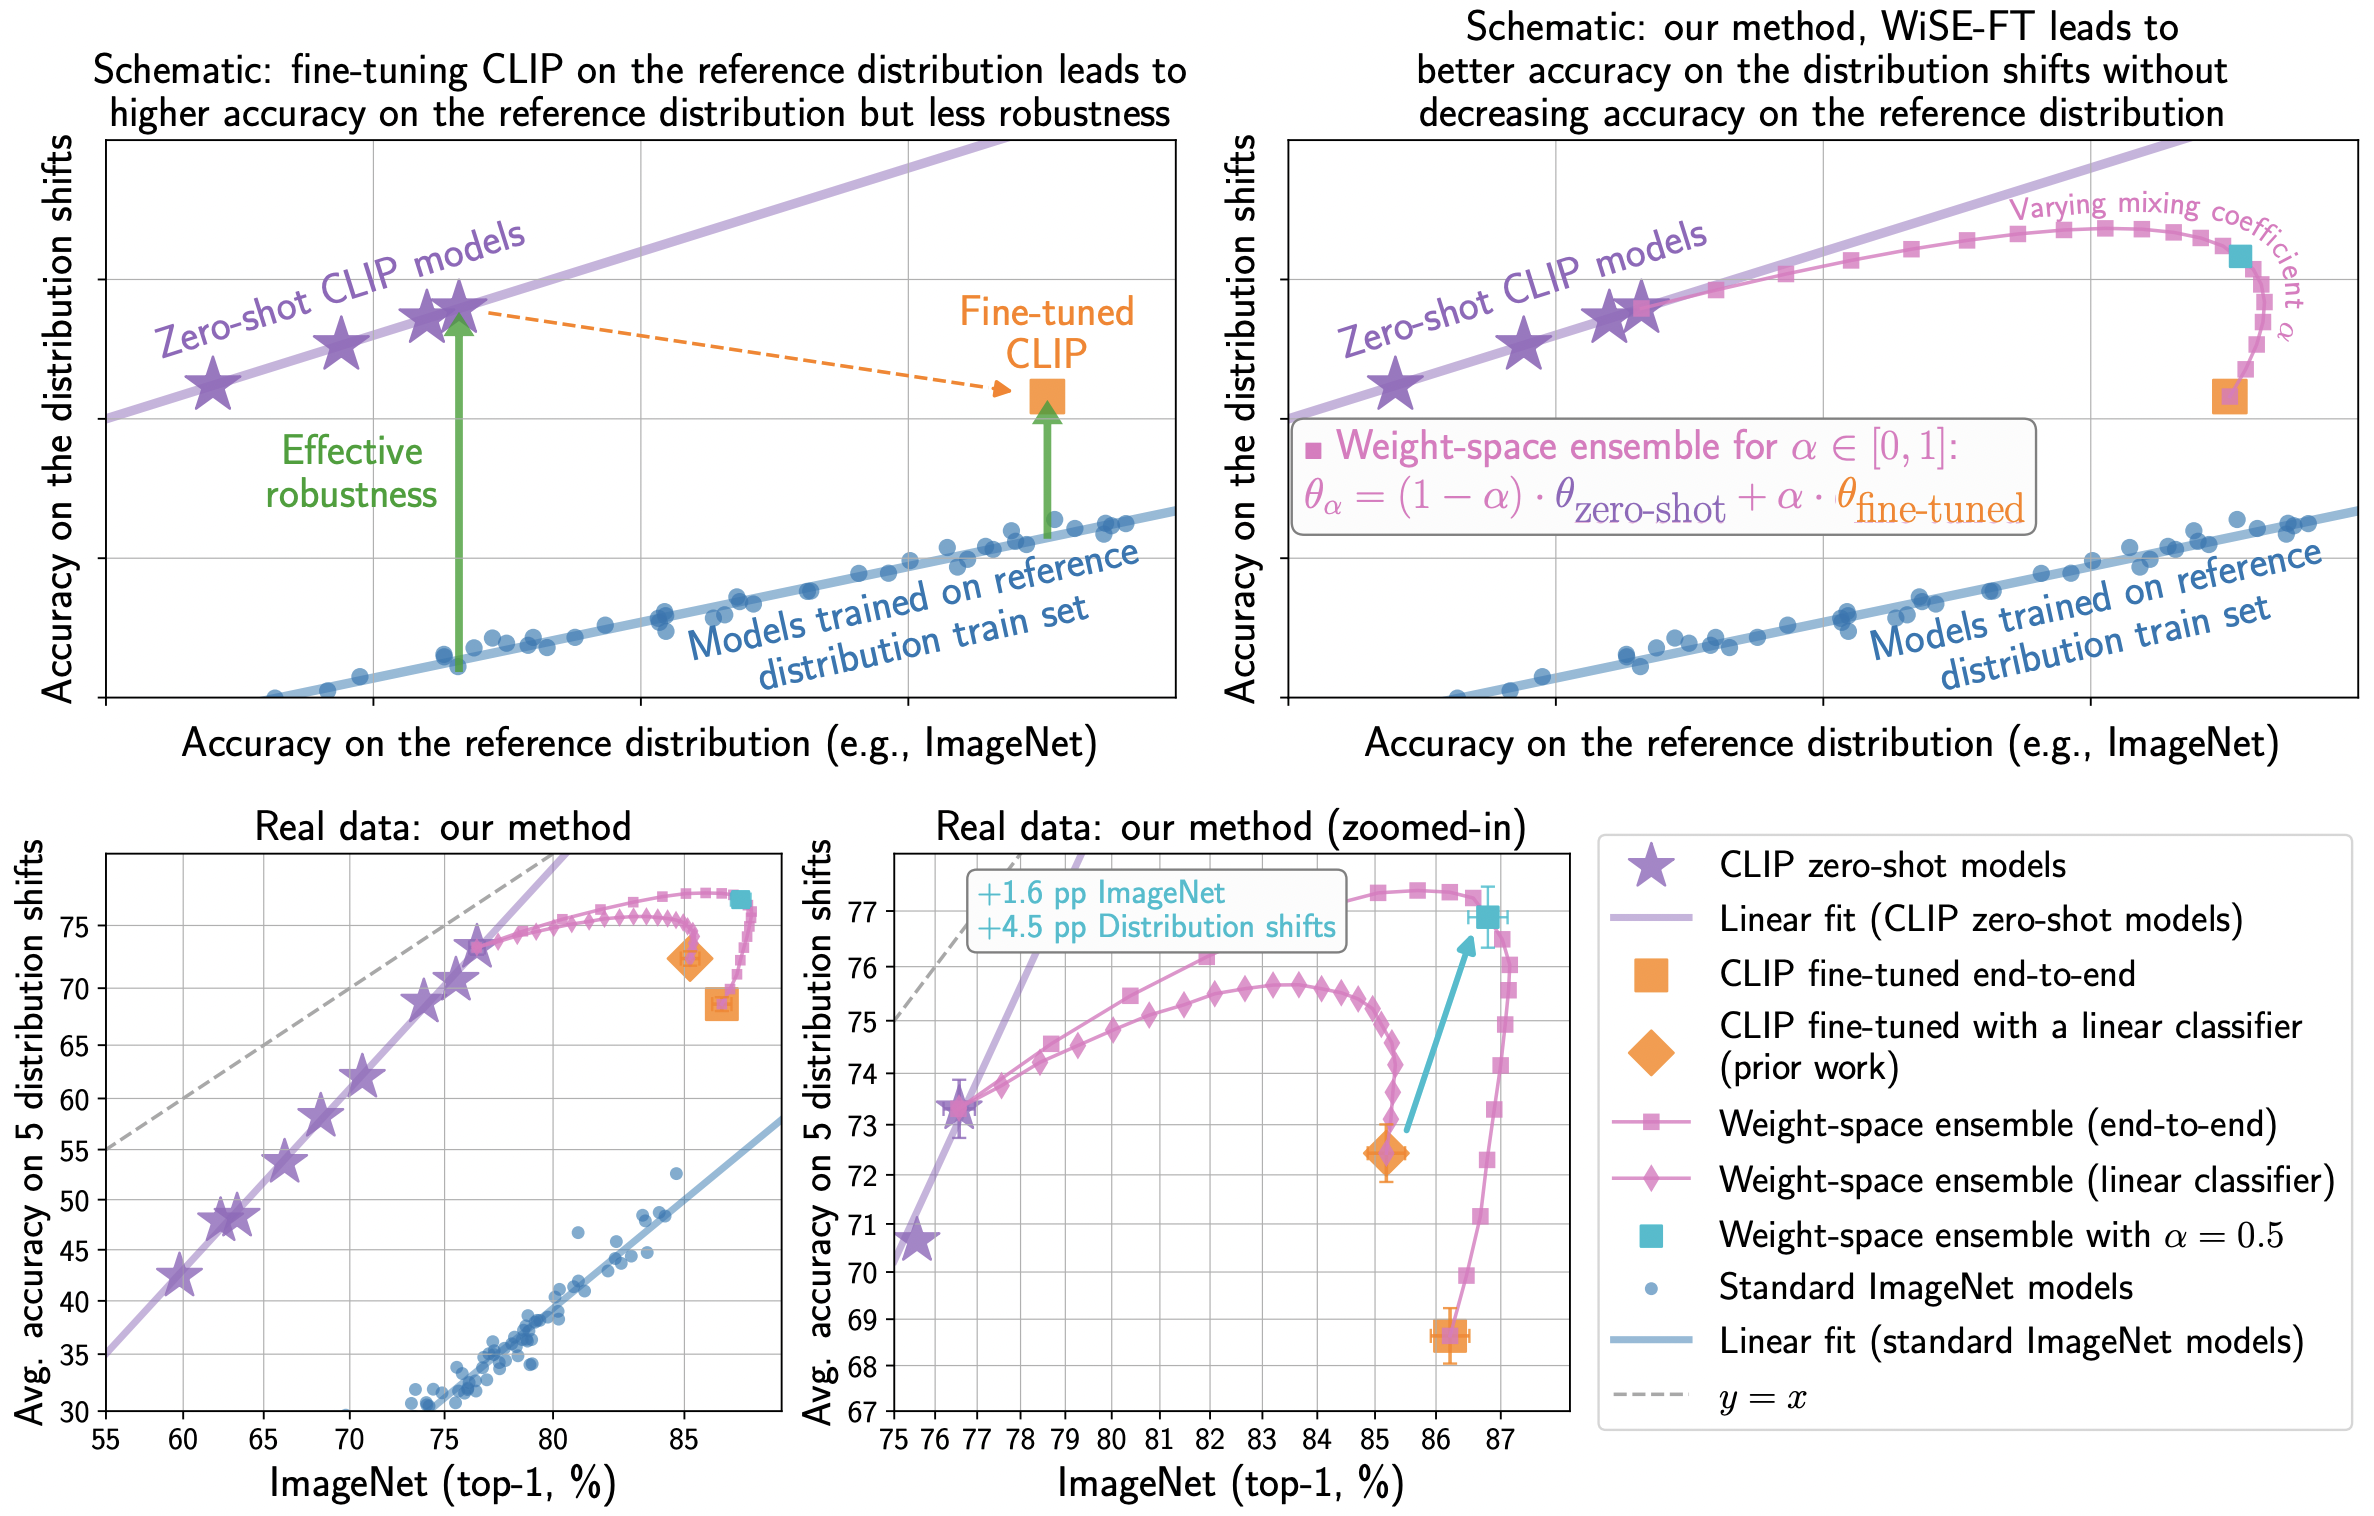

In [2]:
def wse(zeroshot_checkpoint, finetuned_checkpoint, alpha):
    zeroshot = ImageClassifier.load(zeroshot_checkpoint)
    finetuned = ImageClassifier.load(finetuned_checkpoint)
    theta_0 = zeroshot.state_dict()
    theta_1 = finetuned.state_dict()

    # make sure checkpoints are compatible
    assert set(theta_0.keys()) == set(theta_1.keys())
    
    interpolation = {}
    
    # interpolate between checkpoints with mixing coefficient alpha
    theta = {
        key: (1 - alpha) * theta_0[key] + alpha * theta_1[key]
        for key in theta_0.keys()
    }

    # update the model acccording to the new weights
    finetuned.load_state_dict(theta)

    return finetuned


def sweep_alpha_wse(zeroshot_checkpoint, finetuned_checkpoint, distribution='id'):
    assert distribution in ['id', 'ood']
    
    if distribution == 'id':
        eval_datasets = ['ImageNet']
    else:
        eval_datasets = ['ImageNetVidRobust', 'ImageNetSketch', 'ImageNetA', 'ImageNetR']

    accuracies = {}
    for alpha in np.arange(0, 1.01, 0.1):
        model = wse(zeroshot_checkpoint, finetuned_checkpoint, alpha)

        args = argparse.Namespace(
            device='cuda', eval_datasets=eval_datasets, data_location='datasets',
            batch_size=128, results_db='results', freeze_encoder=False
        )
        
        metrics = evaluate(model, args)
        top1_accuracy = np.mean([metrics[key] for key in metrics.keys() if 'top1' in key])
        accuracies[alpha] = np.mean(top1_accuracy)
        print(alpha, accuracies[alpha])

    return accuracies

In [ ]:
zeroshot_checkpoint = 'models/zeroshot.pt'
finetuned_checkpoint = 'models/head_finetuning/checkpoint_10.pt'

accuracies = sweep_alpha_wse(zeroshot_checkpoint, finetuned_checkpoint)

In [84]:
lp_id_accuracies = torch.load('logs/lp_wse_id')
lp_ood_accuracies = torch.load('logs/lp_wse_ood')

ft_id_accuracies = torch.load('logs/ft_wse_id')
ft_ood_accuracies = torch.load('logs/ft_wse_ood')

In [85]:
alphas = np.array(list(lp_id_accuracies.keys()))

assert np.allclose(alphas, np.array(list(lp_ood_accuracies.keys())))

lp_id_acc = list(lp_id_accuracies.values())
lp_ood_acc = list(lp_ood_accuracies.values())

ft_id_acc = list(ft_id_accuracies.values())
ft_ood_acc = list(ft_ood_accuracies.values())

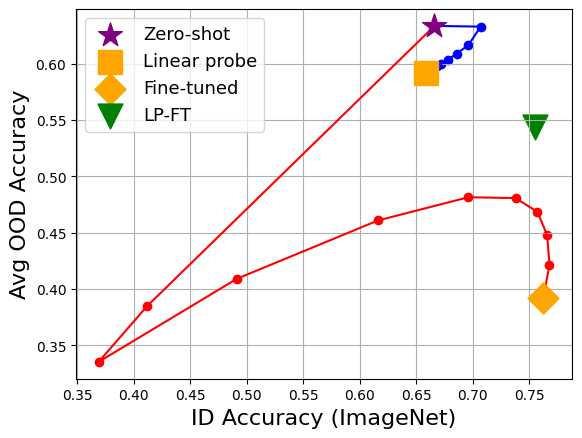

In [95]:
plt.plot(lp_id_acc, lp_ood_acc, c='b')
plt.scatter(lp_id_acc, lp_ood_acc, c='b')

plt.plot(ft_id_acc, ft_ood_acc, c='r')
plt.scatter(ft_id_acc, ft_ood_acc, c='r')

plt.scatter([ft_id_acc[0]], [ft_ood_acc[0]], s=320, marker='*', color='purple', zorder=3, label='Zero-shot')

plt.scatter([lp_id_acc[-1]], [lp_ood_acc[-1]], s=320, marker='s', color='orange', zorder=3, label='Linear probe')
plt.scatter([ft_id_acc[-1]], [ft_ood_acc[-1]], s=250, marker='D', color='orange', zorder=3, label='Fine-tuned')

plt.scatter(lp_ft_id, lp_ft_ood, s=320, marker='v', c='g', label='LP-FT')

plt.legend(fontsize=13)

plt.xlabel('ID Accuracy (ImageNet)', size=16)
plt.ylabel('Avg OOD Accuracy', size=16)

plt.grid()

In [87]:
id_accuracies = torch.load('logs/lp_wse_id')
ood_accuracies = torch.load('logs/lp_wse_ood')

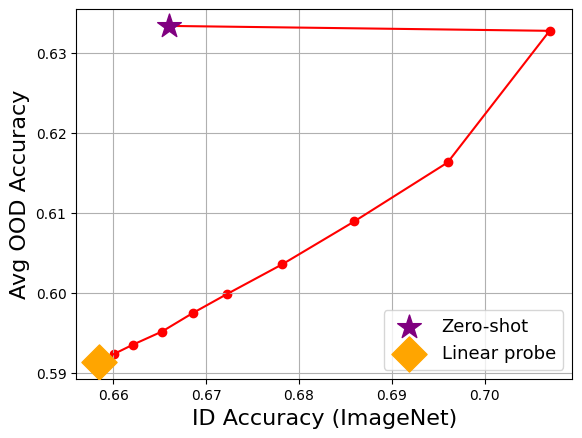

In [90]:
alphas = np.array(list(id_accuracies.keys()))

assert np.allclose(alphas, np.array(list(ood_accuracies.keys())))

id_acc = list(id_accuracies.values())
ood_acc = list(ood_accuracies.values())

plt.plot(id_acc, ood_acc, c='r')
plt.scatter(id_acc, ood_acc, c='r')

plt.scatter([id_acc[0]], [ood_acc[0]], s=320, marker='*', color='purple', zorder=3, label='Zero-shot')
plt.scatter([id_acc[-1]], [ood_acc[-1]], s=320, marker='D', color='orange', zorder=3, label='Linear probe')

plt.legend(fontsize=13)

plt.xlabel('ID Accuracy (ImageNet)', size=16)
plt.ylabel('Avg OOD Accuracy', size=16)

plt.grid()

In [91]:
id_accuracies = torch.load('logs/ft_wse_id')
ood_accuracies = torch.load('logs/ft_wse_ood')

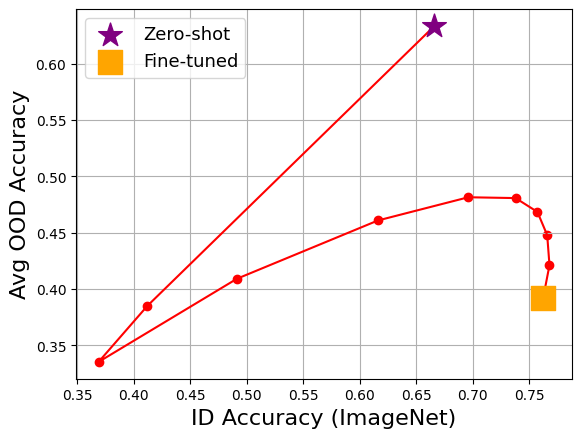

In [92]:
alphas = np.array(list(id_accuracies.keys()))

assert np.allclose(alphas, np.array(list(ood_accuracies.keys())))

id_acc = list(id_accuracies.values())
ood_acc = list(ood_accuracies.values())

plt.plot(id_acc, ood_acc, c='r')
plt.scatter(id_acc, ood_acc, c='r')

plt.scatter([id_acc[0]], [ood_acc[0]], s=320, marker='*', color='purple', zorder=3, label='Zero-shot')
plt.scatter([id_acc[-1]], [ood_acc[-1]], s=320, marker='s', color='orange', zorder=3, label='Fine-tuned')

plt.legend(fontsize=13)

plt.xlabel('ID Accuracy (ImageNet)', size=16)
plt.ylabel('Avg OOD Accuracy', size=16)

plt.grid()